# Architectures classiques d'Autoencoders
## Débruitage et classification automatique d'images + génération de données
disclaimer: exemples récupérés du tutoriel officiel Keras
https://blog.keras.io/building-autoencoders-in-keras.html

Article de review principalement utilisé: <br\>
Charte and al. A practical tutorial on autoencoders for nonlinear feature fusion: Taxonomy, models, software and guidelines, Information Fusion journal, 2018 

lien arxiv pour dl: https://arxiv.org/abs/1801.01586

In [1]:
%pylab inline

pylab.rcParams['figure.figsize'] = (15.0, 10.0)
pylab.rcParams['figure.dpi'] = 150

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [3]:
import numpy as np
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


## Chargement de la donnée

In [4]:
from keras.datasets import mnist

On récupère le fameux dataset MNIST de chiffres manuscrits.

In [5]:
(x_train, _), (x_test, _) = mnist.load_data()

Exemple d'image qui se trouve dans le dataset:

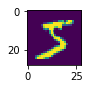

In [6]:
plt.figure(figsize=(1, 1))
plt.imshow(x_train[0])

On normalise le tout.

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [8]:
x_train = x_train[:100, :]
x_test = x_test[:10, :]

## Construction des AutoEncoders

In [9]:
from bdacore.neural_networks.keras_factory import SimpleAutoEncoderFactory, DeepAutoEncoderFactory, \
AutoEncoderClassifier, CNNDenoisingAutoEncoder2DFactory, VariationalAutoEncoderFactory

Dans BDAcore, la classe KerasFactory renvoie habituellement un seul modèle de réseaux de neurones, qu'on passe ensuite en argument d'un wrapper Keras Scikit. Dans le cas des AutoEncoders, on peut avoir besoin d'avoir accès à la couche "centrale", de manière à capturer la représentation "compressée" de la donnée. Pour cela, toutes les factories d'AutoEncoders de BDAcore renvoie le modèle global avec au moins l'encodeur, voire le décodeur dans certains cas.

![autoencoder](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png)

Pour rester "skitlearn compliant", Keras possède un wrapper scikit. Pour rester compatible avec le contrat scikit, étant donné qu'on a besoin d'au moins 2 modèles en même temps (autoencoder + encoder), une classe AutoEncoderClassifier a été créée de manière à avoir un wrapper "skitlearn compliant" encapsulant les 2 modèles.

In [10]:
# petite fonction basée sur le code du tuto pour l'affichage
def plot_images(x_test, decoded_imgs, x_test_reshape_size=(28,28) , decoded_imgs_reshape_size=(28,28), n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):

        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(x_test_reshape_size))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(decoded_imgs_reshape_size))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

La taille de la donnée d'entrée correspond à une image à plat (28 x 28 = 784).

In [11]:
image_size = x_train.shape[1]
image_size

784

### Simple AutoEncoder

In [12]:
ae_factory = SimpleAutoEncoderFactory()
autoencoder, encoder, _ = ae_factory.create_model(encoding_dim=32, input_size=image_size)
clf_keras = AutoEncoderClassifier(autoencoder, encoder)

Architecture en 3 couches classique d'un autoencoder. 

In [15]:
clf_keras.fit(x_train, x_train,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(x_test, x_test))

Train on 100 samples, validate on 10 samples
Epoch 1/50
100/100 [==============================] - 0s 3ms/step - loss: 0.6951 - val_loss: 0.6937
Epoch 2/50
100/100 [==============================] - 0s 53us/step - loss: 0.6943 - val_loss: 0.6930
Epoch 3/50
100/100 [==============================] - 0s 55us/step - loss: 0.6935 - val_loss: 0.6923
Epoch 4/50
100/100 [==============================] - 0s 109us/step - loss: 0.6927 - val_loss: 0.6917
Epoch 5/50
100/100 [==============================] - 0s 62us/step - loss: 0.6920 - val_loss: 0.6910
Epoch 6/50
100/100 [==============================] - 0s 58us/step - loss: 0.6912 - val_loss: 0.6904
Epoch 7/50
100/100 [==============================] - 0s 112us/step - loss: 0.6905 - val_loss: 0.6897
Epoch 8/50
100/100 [==============================] - 0s 68us/step - loss: 0.6898 - val_loss: 0.6891
Epoch 9/50
100/100 [==============================] - 0s 101us/step - loss: 0.6890 - val_loss: 0.6884
Epoch 10/50
100/100 [=======================

Les deux valeurs de loss tournent autour de 0.102, 0.104 (pour info, c'est de la binary crossentropy).

In [16]:
decoded_imgs = clf_keras.predict(x_test)

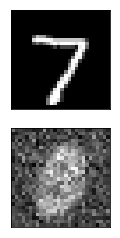

In [17]:
plot_images(x_test, decoded_imgs, n=1)

On obtient ici une représention reconstruite du jeu de test, où l'autoencoder simple (3 couches) s'est contenté d'essayer de reconstruire l'image d'origine avec comme contrainte la couche du milieu qui compresse l'ensemble de la donnée. On peut l'utiliser pour du débruitage ou de la détection d'outliers (ce qui n'est pas ressorti de l'autre côté est soit considéré comme du bruit, soit comme une anomalie au choix), même si la partie débruitage n'est pas forcément extraordinaire dans ce cas précis, vu la simplicité de l'architecture de l'AE.

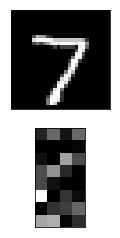

In [18]:
plot_images(x_test, clf_keras.encoded_data_, decoded_imgs_reshape_size=(8,4), n=1)

Il sera intéressant de jeter un oeil à la partie compressée de l'image (couche du milieu) car celle-ci équivaut à effectuer une réduction de dimensions. Dans le cas d'un AE simple, cela revient à effectuer une PCA. Cela fera l'objet d'une application spécifique avec un autre type d'autoencoders qui permet des réductions de dimensions non-linéaires.

### Deep AutoEncoder

In [19]:
ae_factory = DeepAutoEncoderFactory()
autoencoder, encoder = ae_factory.create_model(input_size=image_size, start_layer_size=256, sub_layers_level=4)
clf_keras = AutoEncoderClassifier(autoencoder, encoder)

Architecture en sablier, où l'on donne la taille de départ, et le nombre de sous-couches intermédiaires (taille divisée par 2 à chaque fois).

In [ ]:
clf_keras.fit(x_train, x_train,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(x_test, x_test))

In [ ]:
decoded_imgs = clf_keras.predict(x_test)

In [ ]:
plot_images(x_test, decoded_imgs, n=1)

Même si la loss est quasi identique, on a l'impression que l'AE peine à reconstruire l'image. En fonction des applications, cela peut être voulu, de sorte que plus de bruit sera filtré par exemple. Dans le cas des chiffres manuscrits, le delta entre la sortie et l'entrée pourrait servir à estimer la lisibilité du caractère par un humain (plus le delta est grand, moins le chiffre est lisible à l'origine).

### CNN AutoEncoder

Comme on repasse en 2 dimensions, on recharge les données:

In [21]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [22]:
x_train = x_train[:100, :]
x_test = x_test[:10, :]

In [23]:
ae_factory = CNNDenoisingAutoEncoder2DFactory()
autoencoder, encoder = ae_factory.create_model(shape=(28, 28, 1))
clf_keras = AutoEncoderClassifier(autoencoder, encoder)

Succession de couches de convolution et de max pooling, et même chose dans l'autre sens, avec des couches upsampling à la place des max pooling.

On créé des images bruitées, et on créé une relation entre l'image originale et sa version bruitée en prenant comme entréee l'image bruitée et en cible l'image non bruitée.

In [25]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

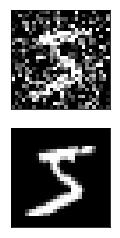

In [26]:
plot_images(x_train_noisy, x_train, n=1)

On donne à l'autoencoder l'image bruitée en entrée avec pour cible l'image non-bruitée.

In [27]:
clf_keras.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 100 samples, validate on 10 samples
Epoch 1/10
100/100 [==============================] - 1s 8ms/step - loss: 0.7390 - val_loss: 0.6763
Epoch 2/10
100/100 [==============================] - 0s 2ms/step - loss: 0.6766 - val_loss: 0.6278
Epoch 3/10
100/100 [==============================] - 0s 2ms/step - loss: 0.6298 - val_loss: 0.5670
Epoch 4/10
100/100 [==============================] - 0s 2ms/step - loss: 0.5718 - val_loss: 0.4983
Epoch 5/10
100/100 [==============================] - 0s 2ms/step - loss: 0.5103 - val_loss: 0.4704
Epoch 6/10
100/100 [==============================] - 0s 2ms/step - loss: 0.4913 - val_loss: 0.4672
Epoch 7/10
100/100 [==============================] - 0s 2ms/step - loss: 0.4844 - val_loss: 0.4587
Epoch 8/10
100/100 [==============================] - 0s 2ms/step - loss: 0.4779 - val_loss: 0.4545
Epoch 9/10
100/100 [==============================] - 0s 2ms/step - loss: 0.4715 - val_loss: 0.4469
Epoch 10/10
100/100 [==============================] - 

On regarde ensuite ce que cela donne si on donne à l'AE des images bruitées jamais rencontrées.

In [28]:
decoded_imgs = clf_keras.predict(x_test_noisy)

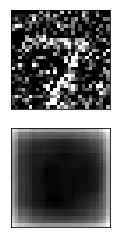

In [29]:
plot_images(x_test_noisy, decoded_imgs, n=1)

Les résultats sont plutôt bons dans l'ensemble et l'AE fait le job.

### Variational AutoEncoder

On recharge les données proprement.

In [30]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [31]:
x_train = x_train[:100, :]
x_test = x_test[:10, :]

In [32]:
ae_factory = VariationalAutoEncoderFactory()
autoencoder, encoder, decoder = ae_factory.create_model(input_size=784, intermediate_dim=256, latent_dim=16, epsilon_std=1.0)
clf_keras = AutoEncoderClassifier(autoencoder, encoder)

Ce type d'AE utiliser une approche bayésienne variationnelle pour l'encodage. On suppose qu'il existe une variable aléatoire latente non observée $y$ qui, par un processus aléatoire, conduit aux observations $x$. Son objectif est donc d'approximer la distribution de la variable latente à partir des observations. Les AE variationnels remplacent les fonctions déterministes dans l'encodeur et le décodeur par des applications stochastiques, et calculent la fonction objectif selon les fonctions de densité des variables aléatoires de la distribution estimée (ici on utilise la loi normale).

Comme ces modèles appartiennent à la catégorie des réseaux de neurones génératifs, ils permettent également de créer de nouvelles données.

In [40]:
clf_keras.fit(x_train, None,
                        epochs=15,
                        batch_size=128,
                        shuffle=True,
                        validation_data=(x_test, None))

Train on 100 samples, validate on 10 samples
Epoch 1/15
100/100 [==============================] - 0s 118us/step - loss: 295.7971 - val_loss: 294.8884
Epoch 2/15
100/100 [==============================] - 0s 163us/step - loss: 283.3232 - val_loss: 281.2496
Epoch 3/15
100/100 [==============================] - 0s 191us/step - loss: 270.3691 - val_loss: 284.6578
Epoch 4/15
100/100 [==============================] - 0s 101us/step - loss: 264.8552 - val_loss: 267.3797
Epoch 5/15
100/100 [==============================] - 0s 102us/step - loss: 256.9158 - val_loss: 258.4368
Epoch 6/15
100/100 [==============================] - 0s 97us/step - loss: 250.7155 - val_loss: 264.4670
Epoch 7/15
100/100 [==============================] - 0s 209us/step - loss: 248.0166 - val_loss: 260.5433
Epoch 8/15
100/100 [==============================] - 0s 214us/step - loss: 239.6353 - val_loss: 252.8483
Epoch 9/15
100/100 [==============================] - 0s 125us/step - loss: 238.4431 - val_loss: 237.2575
Ep

#### Clustering automatique d'images

On prend le jeu de test et on le transforme en sa représentation "compressée" à 16 dimensions. L'objectif est ensuite d'y appliquer un algorithme de réduction de dimension non-linéaire type manifold. Dans ce cas de figure, l'AE permet de réduire la dimension car les algorithmes type manifold ne sont pas faits pour traiter de très grandes dimensions. Ici, on passe de 784 dimensions à 16 dimensions, qu'on va réduire à 2 dimensions, ce qui permettra d'afficher et de faire du clustering classique. On pourrait réduire grâce à l'AE directement à 2 dimensions, mais les résultats sont bien moins bons.

In [41]:
x_test_encoded = encoder.predict(x_test, batch_size=128)

On obtient bien nos 10 000 images de test dans une représentation à 16 dimensions.

In [42]:
x_test_encoded[2].shape

(10, 16)

On construit un dataframe qu'on va utiliser avec une réduction de dimensions type manifold.

In [43]:
df_test = pd.DataFrame(x_test_encoded[2])

In [44]:
df_test.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.110014,0.924425,0.796352,1.077659,-0.116121,-2.138069,-1.360329,-0.121193,2.507831,-0.651001,-0.704277,-0.895097,-0.989126,0.700750,-1.834688,0.274764
1,1.798244,0.013318,1.682636,2.187859,1.281359,0.953046,-2.925138,0.958744,3.020417,0.001254,-0.109269,1.323348,-1.455718,1.670491,0.313840,-0.304688
2,0.574769,0.374225,1.751449,2.343125,1.460200,0.836329,-2.190854,-1.459035,2.881112,-0.485541,-2.434419,0.987045,-0.387929,3.319902,0.966981,-1.333738
3,1.757737,3.535808,3.175558,1.558805,1.297816,-1.376057,-2.920655,-0.007543,0.755235,-1.080010,-1.872491,0.913250,-1.335097,1.723480,-0.646683,-0.939129
4,0.287599,-0.068053,0.895389,1.017585,1.384775,0.819595,-1.263190,-0.622105,1.857936,0.366440,0.207119,-0.579625,-1.286241,0.771950,-0.240163,-0.245597


In [45]:
from sklearn.manifold import TSNE

In [46]:
%%time
clf_man = TSNE()
test_reduc = clf_man.fit_transform(df_test)

CPU times: user 105 ms, sys: 2.45 ms, total: 108 ms
Wall time: 106 ms


On est en mesure d'afficher les images dans un espace à 2 dimensions, et à l'oeil, on se rend compte qu'avec un processus complétement automatique, on s'en sort plutôt bien. Même si t-SNE est à la base fait pour de la visualisation, il permet également de bien séparer les différentes images.

Pour finaliser l'approche, on applique sur cet espace à 2 dimensions un algorithme de clustering permettant de spécifier le nombre de classes (ici 10), et on mesure ensuite avec la V-Mesure le résultat.

In [48]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import homogeneity_completeness_v_measure

In [49]:
clf_clust = AgglomerativeClustering(n_clusters=10)

In [50]:
clusters = clf_clust.fit_predict(test_reduc)

In [56]:
homogeneity_completeness_v_measure(labels_true=y_test[:10],labels_pred=clusters)

(0.9999999999999999, 0.8193820026016113, 0.9007256325828685)

La V-Mesure obtient environ 84%, on arrive donc à capturer 84% de l'information (de l'entropie) de manière juste, et de manière automatique.

#### Génération d'images
La particularité des modèles variationels d'AE est qu'ils appartiennent à la catégorie des réseaux de neurones génératifs. On peut donc s'amuser à générer des données à envoyer à la couche du milieu, demander à la partie décodeur de sortir un résultat et de voir ce que cela donne.

Pour générer les données, il faut donc fournir des tableaux de dimension 16. On choisit la distribution normale pour tirer aléatoirement des valeurs puisque c'est cette dernière qui est estimée par l'AE a priori (approche bayésienne). Pour l'exemple, on génère 15 lignes de 16 valeurs.

In [52]:
z_sample = np.random.normal(size=(15,16))

In [53]:
x_decoded = decoder.predict(z_sample)

On affiche la représention compressée de taille 16 générée aléatoirement, et le résultat obtenu en-dessous par le décodeur.

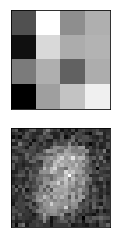

In [54]:
plot_images(z_sample, x_decoded , x_test_reshape_size=(4,4), n=1)

Parfois les images générées ne font pas sens, mais on est tout de même en mesure de créer des images de chiffres manuscrits qui ne ressemblent à aucun de ceux présents dans le dataset d'origine.

#### Debrief:
Un gros pavé que ce tutoriel sur les autoencoders, et un grand nombre de papiers existent avec des usages assez surprenants. Dans notre quotidien, l'approche non-supervisée de classification d'image (ou autre source de données) peut être certainement utile.